# pip installs

In [9]:
!pip install datasets
!pip install wordcloud
!pip install gensim nltk scikit-learn tqdm
# Optional (for training/using GloVe locally):
!pip install glove-python-binary
# If you prefer pretrained GloVe vectors (recommended), download them manually from the GloVe project page:
# https://nlp.stanford.edu/projects/glove/



ERROR: Could not find a version that satisfies the requirement glove-python-binary (from versions: none)
ERROR: No matching distribution found for glove-python-binary


   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------- ----------------------------- 0.3/1.0 MB ? eta -:--:--
   ---------------------------------------- 1.0/1.0 MB 6.1 MB/s eta 0:00:00


# imports


In [64]:
#title
import numpy as np
import pandas as pd
import seaborn as sns
from datasets import load_dataset
import matplotlib.pyplot as plt
import re
import string
from matplotlib.patches import Patch
import nltk
from nltk import pos_tag, word_tokenize
from nltk.tokenize import sent_tokenize, word_tokenize
from wordcloud import WordCloud
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer



# downlodes

In [3]:
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
nltk.download("punkt_tab")
nltk.download("averaged_perceptron_tagger_eng")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Magsihim_AI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Magsihim_AI\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Magsihim_AI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Magsihim_AI\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

# DATA creation

In [4]:
new_dataset = load_dataset("dmitva/human_ai_generated_text")
new_data = new_dataset["train"].to_pandas()
new_data.head()

README.md: 0.00B [00:00, ?B/s]

c:\Users\Magsihim_AI\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Magsihim_AI\.cache\huggingface\hub\datasets--dmitva--human_ai_generated_text. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to re

model_training_dataset.csv:   0%|          | 0.00/3.93G [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000000 [00:00<?, ? examples/s]

,id,human_text,ai_text,instructions
0,cc902a20-27c4-4c18-8012-048a328206d1,Also they feel more comfortable at home. Some ...,"\n\nTherefore, when it comes to allowing stude...",Task: Write a persuasive essay on whether or n...
1,c4d2fbe3-e966-479d-89c4-62e1729b6255,"I can get another job to work on the weekends,...",It is important to weigh both the potential co...,Task: Research the advantages and disadvantage...
2,710f585e-5e98-42b8-81f6-265d7c934645,parents and school should agree on the desicio...,To ensure that parents are comfortable with th...,Task: \n\n1. Talk to your parents before takin...
3,e4db6c43-7b6b-4385-9b67-04652c71df0c,"Base in my experiences I'm growing, I try hard...","As Emerson said, by going confidently in the d...",Task: Write an essay discussing the benefits o...
4,7a48bcf1-cbb4-4f41-b99a-ea859c56afdf,Many people around the world have different ch...,"Parents, for example, can have a major influen...",Task: Research and discuss how character trait...


In [51]:
new_data= new_data[['human_text','instructions']]
new_data

,human_text,instructions
0,Also they feel more comfortable at home. Some ...,Task: Write a persuasive essay on whether or n...
1,"I can get another job to work on the weekends,...",Task: Research the advantages and disadvantage...
2,parents and school should agree on the desicio...,Task: \n\n1. Talk to your parents before takin...
3,"Base in my experiences I'm growing, I try hard...",Task: Write an essay discussing the benefits o...
4,Many people around the world have different ch...,Task: Research and discuss how character trait...
...,...,...
999995,You can meet up with your family at the park. ...,Task: Research reasons why people might find c...
999996,Even small chores prepare us for something big...,Task: \n\n1. Research the history of the US an...
999997,"Sometimes people say, ""technology is bad becau...",Task: Write an essay exploring how technology ...
999998,if we had enough time it would had really help...,Task: \n1. Research the effects of adding an a...


In [ ]:


client = OpenAI(api_key="API_KEY ")

df = new_data.copy()   # full dataset
output_path = "ai_responses_progress.csv"
backup_path = "ai_responses_backup.csv"

# --- RESUME FROM CHECKPOINT IF EXISTS ---
if os.path.exists(output_path):
    print("Loading existing progress file...")
    df = pd.read_csv(output_path)
else:
    df["ai_response"] = df.get("ai_response", None)


def generate_ai_response(instruction):
    try:
        completion = client.chat.completions.create(
            model="gpt-4.1-mini-2025-04-14",
            messages=[
                {"role": "system", "content": 
                 "You are an AI assistant. Provide a full, coherent answer. Output ONLY the answer."},
                {"role": "user", "content": str(instruction)}
            ],
            max_completion_tokens=500,
            temperature=0.7
        )
        return completion.choices[0].message.content.strip()

    except Exception as e:
        print("API error, retrying in 5 sec:", e)
        time.sleep(5)
        return generate_ai_response(instruction)


# ------------------------------
# PROCESS LOOP (SAFE + RESUMABLE)
# ------------------------------

save_every = 50
processed = 0

for idx, row in df.iterrows():

    # Skip rows already processed
    if pd.notna(row.get("ai_response", None)) and row["ai_response"] != "":
        continue

    instruction = str(row["instructions"])

    print(f"\nProcessing row {idx}: {instruction[:80]}...")

    ai_text = generate_ai_response(instruction)
    df.at[idx, "ai_response"] = ai_text

    processed += 1

    # SAVE EVERY 50 ROWS
    if processed % save_every == 0:
        print("Saving progress...")
        df.to_csv(output_path, index=False)
        df.to_csv(backup_path, index=False)

# Final save
df.to_csv(output_path, index=False)
df.to_csv(backup_path, index=False)

print("DONE!")


In [ ]:


client = OpenAI(api_key="API_KEY")

df_small = new_data.head(10).copy()

ai_responses = []

for idx, row in df_small.iterrows():
    instruction = str(row['instructions']).strip()

    completion = client.chat.completions.create(
        model="gpt-4.1-mini-2025-04-14",
        messages=[
            {"role": "system", "content": 
             "You are an AI assistant. Your job is to answer the user's instruction fully, "
             "even if the instruction text is messy, incomplete, or contains formatting noise. "
             "Always provide a complete, coherent answer. Output ONLY the answer."},
            {"role": "user", "content": instruction}
        ],
        max_completion_tokens=500,
        temperature=0.7
    )

    ai_text = completion.choices[0].message.content.strip()
    ai_responses.append(ai_text)
    print(instruction)
    print("\n",ai_text)

df_small["ai_response"] = ai_responses

print(df_small)


Task: Write a persuasive essay on whether or not classes from home should be offered as an option for students to attend. Describe the advantages and disadvantages of attending classes from home, as well as the effect it may have on learning. Cite examples to support your argument.

 In recent years, the option to attend classes from home has become increasingly popular, especially with advancements in technology and the global impact of the COVID-19 pandemic. Offering classes from home as an option for students presents both significant advantages and notable disadvantages, each influencing the learning experience in distinct ways. Ultimately, providing this choice can enhance educational accessibility and flexibility but requires careful consideration to mitigate potential drawbacks.

One of the primary advantages of attending classes from home is the flexibility it offers. Students can learn at their own pace and schedule, which accommodates different learning styles and personal ci

In [61]:
df_small

,human_text,instructions,ai_response
0,Also they feel more comfortable at home. Some ...,Task: Write a persuasive essay on whether or n...,"In recent years, the option to attend classes ..."
1,"I can get another job to work on the weekends,...",Task: Research the advantages and disadvantage...,"**The Four-Day School Week: Advantages, Disadv..."
2,parents and school should agree on the desicio...,Task: \n\n1. Talk to your parents before takin...,5. Make sure that activities you choose align ...
3,"Base in my experiences I'm growing, I try hard...",Task: Write an essay discussing the benefits o...,"Ralph Waldo Emerson once said, “Do not go wher..."
4,Many people around the world have different ch...,Task: Research and discuss how character trait...,Character traits in humans are formed through ...
5,"Online classes, i think that if students reall...",Task: Write an essay exploring the pros and co...,Online classes have become an increasingly com...
6,I kept practicing over the off season working ...,Task: Task:\n1. Research prominent successful ...,1. Research on Prominent Individuals and Failu...
7,CAN WE ACCOMPLISH BY ALWAYS DOING SOMETHING OR...,Task: \n\n1. Research the quotation “Determine...,“Determine never to be idle... It is wonderful...
8,"Generic_Name\n\nMarch 14, 2019\n\nWriting SOL\...",Task: Write an essay about the impact your gra...,My grandfather played a significant role in nu...
9,if you get in bad trouble you can probubly fix...,Task: \n-----------------------------------\nR...,Making the Right Decision in Life: Understandi...


In [62]:
df_small['ai_response'][2]

'5. Make sure that activities you choose align with your interests and goals, and that they have a manageable schedule to maintain a healthy balance between schoolwork and extracurricular involvement.'

In [63]:
df_small["length AI"] = df_small["ai_response"].str.len()
df_small["length Human"] = df_small["human_text"].str.len()
df_small


,human_text,instructions,ai_response,length AI,length Human
0,Also they feel more comfortable at home. Some ...,Task: Write a persuasive essay on whether or n...,"In recent years, the option to attend classes ...",3152,2464
1,"I can get another job to work on the weekends,...",Task: Research the advantages and disadvantage...,"**The Four-Day School Week: Advantages, Disadv...",2810,2708
2,parents and school should agree on the desicio...,Task: \n\n1. Talk to your parents before takin...,5. Make sure that activities you choose align ...,199,2581
3,"Base in my experiences I'm growing, I try hard...",Task: Write an essay discussing the benefits o...,"Ralph Waldo Emerson once said, “Do not go wher...",2785,1799
4,Many people around the world have different ch...,Task: Research and discuss how character trait...,Character traits in humans are formed through ...,2637,1119
5,"Online classes, i think that if students reall...",Task: Write an essay exploring the pros and co...,Online classes have become an increasingly com...,3003,1106
6,I kept practicing over the off season working ...,Task: Task:\n1. Research prominent successful ...,1. Research on Prominent Individuals and Failu...,2662,2262
7,CAN WE ACCOMPLISH BY ALWAYS DOING SOMETHING OR...,Task: \n\n1. Research the quotation “Determine...,“Determine never to be idle... It is wonderful...,2645,2879
8,"Generic_Name\n\nMarch 14, 2019\n\nWriting SOL\...",Task: Write an essay about the impact your gra...,My grandfather played a significant role in nu...,1308,5408
9,if you get in bad trouble you can probubly fix...,Task: \n-----------------------------------\nR...,Making the Right Decision in Life: Understandi...,2002,2203


# EDA 1

In [3]:
#loading data
dataset = load_dataset("artem9k/ai-text-detection-pile")
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['source', 'id', 'text'],
        num_rows: 1392522
    })
})


In [ ]:

data = dataset["train"].to_pandas()
data.head()

,source,id,text
0,human,0,12 Years a Slave: An Analysis of the Film Essa...
1,human,1,20+ Social Media Post Ideas to Radically Simpl...
2,human,2,2022 Russian Invasion of Ukraine in Global Med...
3,human,3,533 U.S. 27 (2001) Kyllo v. United States: The...
4,human,4,A Charles Schwab Corporation Case Essay\n\nCha...


In [ ]:
#null
print(data.isnull().sum())

source    0
id        0
text      0
dtype: int64


source
human    1028146
ai        364376
Name: count, dtype: int64


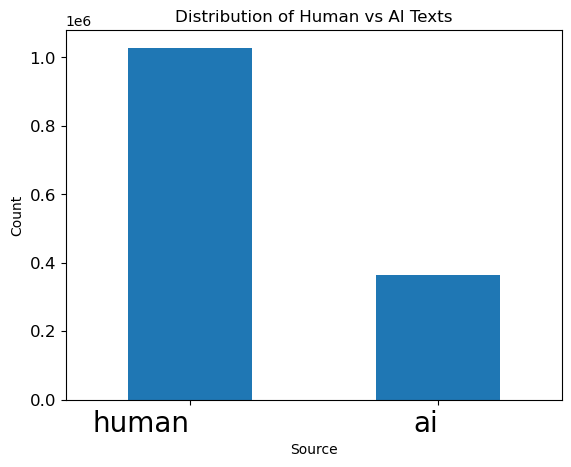

In [6]:
print(data["source"].value_counts())
data["source"].value_counts().plot(kind="bar")
plt.title("Distribution of Human vs AI Texts")
plt.xlabel("Source")
plt.ylabel("Count")
plt.xticks(fontsize=20, rotation=0, ha="right")                # Bigger x-ticks, rotated for readability
plt.yticks(fontsize=12)    
plt.show()

# data engineering 1

In [7]:
#balancing data to 300,000 rows each

human_df = data[data["source"] == "human"].sample(n=500000, random_state=42)
ai_df    = data[data["source"] == "ai"].sample(n=300000, random_state=42)


df = pd.concat([human_df, ai_df]).reset_index(drop=True)

print(df["source"].value_counts())

source
human    500000
ai       300000
Name: count, dtype: int64


# EDA 2

In [8]:
#text length mean 

df["text_length"] = df["text"].str.len()

print("text length by source: ",df.groupby("source")["text_length"].mean())

text length by source:  source
ai       2219.645987
human    2457.011402
Name: text_length, dtype: float64


In [9]:
print("text length by source: ",df.groupby("source")["text_length"].median())

text length by source:  source
ai       1771.0
human     996.0
Name: text_length, dtype: float64


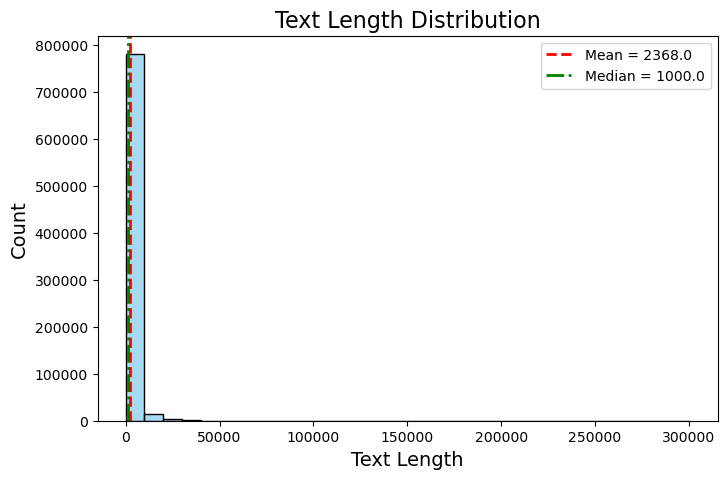

In [10]:


plt.figure(figsize=(8,5))

# Plot a single histogram (no separation by source)
sns.histplot(df["text_length"], bins=30, kde=False, color="skyblue")

# Calculate stats
mean_val = df["text_length"].mean()
median_val = df["text_length"].median()

# Add lines
plt.axvline(mean_val, color="red", linestyle="--", linewidth=2, label=f"Mean = {mean_val:.1f}")
plt.axvline(median_val, color="green", linestyle="-.", linewidth=2, label=f"Median = {median_val:.1f}")

# Titles & labels
plt.title("Text Length Distribution", fontsize=16)
plt.xlabel("Text Length", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.legend()

plt.show()


In [ ]:
# counting sentences

def count_sentences(text):
    if not isinstance(text, str) or not text.strip():
        return 0
    # Split by ., !, ? followed by space or end of string
    sentences = re.split(r'[.!?]+(?:\s|$)', text.strip())
    # Remove empty strings
    sentences = [s for s in sentences if s]
    return len(sentences)

df["sentence_count"] = df["text"].apply(count_sentences)

In [12]:
print(df.groupby("source")["sentence_count"].mean())       # average sentences


source
ai       17.901023
human    24.897236
Name: sentence_count, dtype: float64


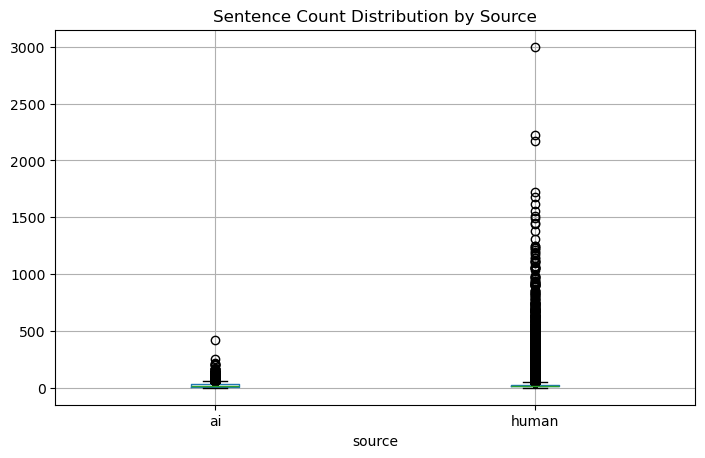

In [13]:
df.boxplot(column="sentence_count", by="source", figsize=(8,5))
plt.title("Sentence Count Distribution by Source")
plt.suptitle("")
plt.show()

In [14]:
def count_words(text):
    if not isinstance(text, str) or not text.strip():
        return 0
    return len(text.split())

def avg_words_per_sentence(text):
    if not isinstance(text, str) or not text.strip():
        return 0
    # Split into sentences
    sentences = re.split(r'[.!?]+(?:\s|$)', text.strip())
    sentences = [s for s in sentences if s.strip()]
    if not sentences:
        return 0
    # Count words in each sentence
    word_counts = [len(s.split()) for s in sentences]
    return sum(word_counts) / len(word_counts)

df["word_count"] = df["text"].apply(count_words)
df["avg_words_per_sentence"] = df["text"].apply(avg_words_per_sentence)


        word_count  avg_words_per_sentence
source                                    
ai      386.738653               23.392167
human   405.118214               17.566498


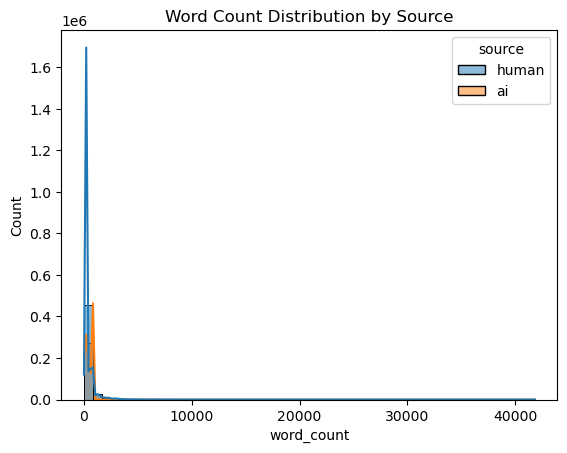

In [15]:
print(df.groupby("source")[["word_count", "avg_words_per_sentence"]].mean())
sns.histplot(data=df, x="word_count", hue="source", kde=True, bins=50)
plt.title("Word Count Distribution by Source")
plt.show()

In [16]:
punctuations = string.punctuation  # !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~

# Count occurrences of each punctuation in every text
for p in punctuations:
    df[f"count_{p}"] = df["text"].str.count(re.escape(p))

In [17]:
punct_summary = df.groupby("source")[[col for col in df.columns if col.startswith("count_")]].sum().T
punct_summary.columns = ["AI", "Human"] if "ai" in punct_summary.columns else punct_summary.columns
print(punct_summary)

              AI     Human
count_!    96275    313159
count_"  2049144    866677
count_#    21826     37229
count_$   117155    108328
count_%    47173    114948
count_&    24074    230407
count_'  2262153   3457076
count_(   410936   1313299
count_)   425297   1320245
count_*    19702    475409
count_+    20048     40980
count_,  5546386  10862985
count_-  1117269   2004292
count_.  5896752  13246497
count_/   193551    305179
count_:   449305    809063
count_;    84820    249945
count_<    14818     16461
count_=    36690     73914
count_>    22284     35592
count_?   206910    568016
count_@    18400     22277
count_[    68904     72659
count_\     4636      6836
count_]    67547     73054
count_^      800     10039
count__    61784    177666
count_`     1558   1404285
count_{     8643     12292
count_|    13480     17815
count_}     8302     11802
count_~     3603     14607


In [18]:
punct_avg = df.groupby("source")[[col for col in df.columns if col.startswith("count_")]].mean().T
print(punct_avg)

source          ai      human
count_!   0.320917   0.626318
count_"   6.830480   1.733354
count_#   0.072753   0.074458
count_$   0.390517   0.216656
count_%   0.157243   0.229896
count_&   0.080247   0.460814
count_'   7.540510   6.914152
count_(   1.369787   2.626598
count_)   1.417657   2.640490
count_*   0.065673   0.950818
count_+   0.066827   0.081960
count_,  18.487953  21.725970
count_-   3.724230   4.008584
count_.  19.655840  26.492994
count_/   0.645170   0.610358
count_:   1.497683   1.618126
count_;   0.282733   0.499890
count_<   0.049393   0.032922
count_=   0.122300   0.147828
count_>   0.074280   0.071184
count_?   0.689700   1.136032
count_@   0.061333   0.044554
count_[   0.229680   0.145318
count_\   0.015453   0.013672
count_]   0.225157   0.146108
count_^   0.002667   0.020078
count__   0.205947   0.355332
count_`   0.005193   2.808570
count_{   0.028810   0.024584
count_|   0.044933   0.035630
count_}   0.027673   0.023604
count_~   0.012010   0.029214


In [19]:
df.head()

,source,id,text,text_length,sentence_count,word_count,avg_words_per_sentence,count_!,"count_""",count_#,...,count_[,count_\,count_],count_^,count__,count_`,count_{,count_|,count_},count_~
0,human,255674,From Trailville\n\nUpper Des Plaines River Can...,4708,38,782,20.578947,0,2,0,...,0,0,0,0,0,0,0,0,0,0
1,human,72144,Coca-Cola Company’s Performance Measurement Es...,2105,20,318,15.900000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,human,829552,"I can't stop it, you won't like it, you should...",1000,13,184,14.153846,3,0,0,...,0,0,0,0,0,14,0,0,0,0
3,human,332556,"American Sniper, the Clint Eastwood movie abou...",924,9,161,17.888889,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,human,999435,eating them.'' His jaw was clenched so tight t...,992,12,185,15.416667,0,0,0,...,0,0,0,0,0,6,0,0,0,0


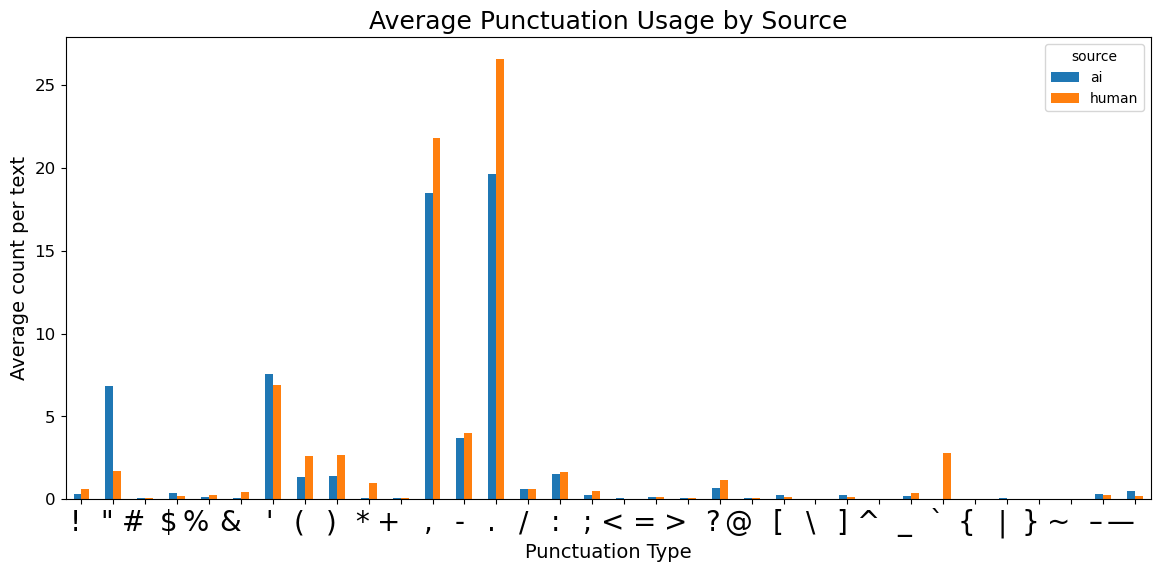

In [69]:
import string
import re
import matplotlib.pyplot as plt

# Define punctuation characters (add em dash and en dash)
punctuations = string.punctuation + "–—"  # en dash (–) and em dash (—)

# Count occurrences of each punctuation in every text
for p in punctuations:
    # Create safe column names by replacing unusual symbols with readable names
    safe_p = p
    if p == "–":
        safe_p = "endash"
    elif p == "—":
        safe_p = "emdash"
    df[f"count_{safe_p}"] = df["text"].str.count(re.escape(p))

# Compute averages by source
punct_avg = (
    df.groupby("source")[
        [col for col in df.columns if col.startswith("count_")]
    ]
    .mean()
    .T
)
punct_avg.index = (
    punct_avg.index.str.replace("count_", "", regex=False)
    .str.replace("endash", "–", regex=False)
    .str.replace("emdash", "—", regex=False)
)

# Plot
punct_avg.plot(kind="bar", figsize=(14, 6))

plt.title("Average Punctuation Usage by Source", fontsize=18)
plt.ylabel("Average count per text", fontsize=14)
plt.xlabel("Punctuation Type", fontsize=14)
plt.xticks(fontsize=20, rotation=0, ha="right")
plt.yticks(fontsize=12)

plt.show()


In [21]:
df["punct_total"] = df["text"].apply(lambda x: len(re.findall(rf"[{re.escape(string.punctuation)}]", str(x))))
avg_punct = df.groupby("source")["punct_total"].mean()
print(avg_punct)

source
ai       64.400750
human    76.546066
Name: punct_total, dtype: float64


In [22]:
df["unique_ratio"] = df["text"].apply(lambda x: len(set(x.split())) / len(x.split()) if len(x.split()) > 0 else 0)
df.head()

,source,id,text,text_length,sentence_count,word_count,avg_words_per_sentence,count_!,"count_""",count_#,...,count_],count_^,count__,count_`,count_{,count_|,count_},count_~,punct_total,unique_ratio
0,human,255674,From Trailville\n\nUpper Des Plaines River Can...,4708,38,782,20.578947,0,2,0,...,0,0,0,0,0,0,0,0,121,0.466752
1,human,72144,Coca-Cola Company’s Performance Measurement Es...,2105,20,318,15.900000,0,0,0,...,0,0,0,0,0,0,0,0,41,0.591195
2,human,829552,"I can't stop it, you won't like it, you should...",1000,13,184,14.153846,3,0,0,...,0,0,0,14,0,0,0,0,77,0.728261
3,human,332556,"American Sniper, the Clint Eastwood movie abou...",924,9,161,17.888889,0,0,0,...,0,0,0,0,0,0,0,0,22,0.720497
4,human,999435,eating them.'' His jaw was clenched so tight t...,992,12,185,15.416667,0,0,0,...,0,0,0,6,0,0,0,0,36,0.718919


In [23]:
avg_unique_ratio = df.groupby("source")["unique_ratio"].mean()
print(avg_unique_ratio)

source
ai       0.595630
human    0.650203
Name: unique_ratio, dtype: float64


<Axes: xlabel='source', ylabel='unique_ratio'>

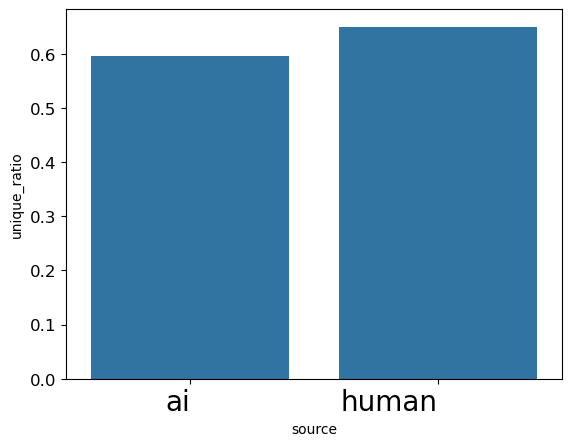

In [24]:
plt.xticks(fontsize=20, rotation=0, ha="right")                # Bigger x-ticks, rotated for readability
plt.yticks(fontsize=12)    
sns.barplot(data=avg_unique_ratio)

# data engineering 2

In [25]:
df.head()

,source,id,text,text_length,sentence_count,word_count,avg_words_per_sentence,count_!,"count_""",count_#,...,count_],count_^,count__,count_`,count_{,count_|,count_},count_~,punct_total,unique_ratio
0,human,255674,From Trailville\n\nUpper Des Plaines River Can...,4708,38,782,20.578947,0,2,0,...,0,0,0,0,0,0,0,0,121,0.466752
1,human,72144,Coca-Cola Company’s Performance Measurement Es...,2105,20,318,15.900000,0,0,0,...,0,0,0,0,0,0,0,0,41,0.591195
2,human,829552,"I can't stop it, you won't like it, you should...",1000,13,184,14.153846,3,0,0,...,0,0,0,14,0,0,0,0,77,0.728261
3,human,332556,"American Sniper, the Clint Eastwood movie abou...",924,9,161,17.888889,0,0,0,...,0,0,0,0,0,0,0,0,22,0.720497
4,human,999435,eating them.'' His jaw was clenched so tight t...,992,12,185,15.416667,0,0,0,...,0,0,0,6,0,0,0,0,36,0.718919


In [26]:
human_df = data[data["source"] == "human"].sample(n=900000, random_state=42)
ai_df    = data[data["source"] == "ai"].sample(n=300000, random_state=42)


df = pd.concat([human_df, ai_df]).reset_index(drop=True)

print(df["source"].value_counts())

source
human    900000
ai       300000
Name: count, dtype: int64


In [27]:
df["text_length"] = df["text"].str.len()

print("text length by source: ",df.groupby("source")["text_length"].mean())

text length by source:  source
ai       2219.645987
human    2467.671636
Name: text_length, dtype: float64


In [28]:
df_small = df.loc[df['text_length']<700]

In [29]:
len(df_small)

159480

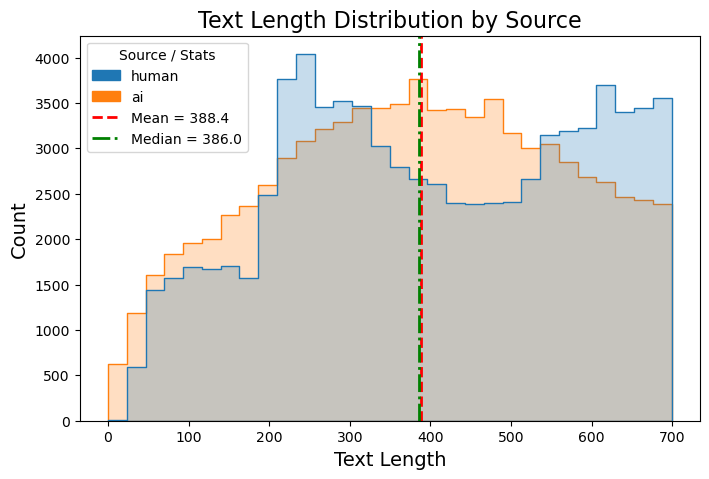

In [30]:

plt.figure(figsize=(8,5))

# Plot histogram
ax = sns.histplot(
    data=df_small,
    x="text_length",
    hue="source",
    bins=30,
    kde=False,
    element="step",   # step outline style
    stat="count"
)

# Calculate stats
mean_val = df_small["text_length"].mean()
median_val = df_small["text_length"].median()

# Add mean/median lines
line_mean = plt.axvline(mean_val, color="red", linestyle="--", linewidth=2,)
line_median = plt.axvline(median_val, color="green", linestyle="-.", linewidth=2)

# --- Build legend manually ---
# Get seaborn's default palette mapping
palette = sns.color_palette(n_colors=df_small["source"].nunique())
sources = df_small["source"].unique()

# Make colored patches for AI/Human
handles = [Patch(facecolor=palette[i], edgecolor=palette[i], label=s) for i, s in enumerate(sources)]

# Add mean/median lines
handles += [line_mean, line_median]
labels = list(sources) + [f"Mean = {mean_val:.1f}", f"Median = {median_val:.1f}"]

plt.legend(handles, labels, title="Source / Stats")

# Titles & labels
plt.title("Text Length Distribution by Source", fontsize=16)
plt.xlabel("Text Length", fontsize=14)
plt.ylabel("Count", fontsize=14)

plt.show()


source
ai       81495
human    77985
Name: count, dtype: int64


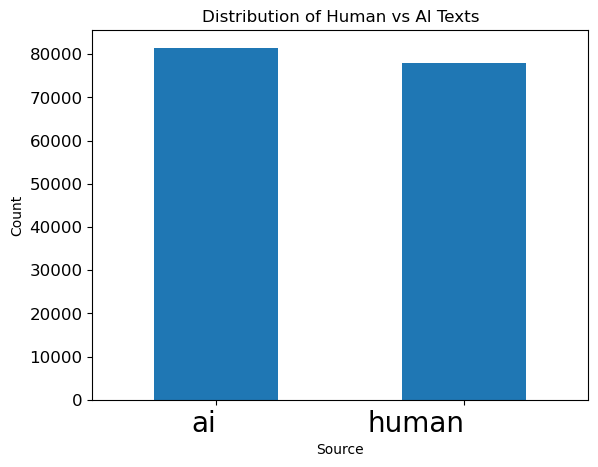

In [31]:
print(df_small["source"].value_counts())
df_small["source"].value_counts().plot(kind="bar")
plt.title("Distribution of Human vs AI Texts")
plt.xlabel("Source")
plt.ylabel("Count")
plt.xticks(fontsize=20, rotation=0, ha="right")                # Bigger x-ticks, rotated for readability
plt.yticks(fontsize=12)    
plt.show()

In [37]:
df_small.to_csv("df_small.csv", index=False)


# creation of small_df

In [2]:
df_small = pd.read_csv("df_small.csv")


# EDA of small DF

In [5]:
df_small.head()

,source,id,text,text_length
0,human,307353,Our founders are experienced tech industry pro...,333
1,human,281747,William W. Campbell Lippincott Williams & Wilk...,678
2,human,418560,"Bagpipes ( and bugles , also used in such fune...",643
3,human,727582,"I finished it in one binge read, and I think i...",549
4,human,427526,The longer the blonder the hair the more press .,48


In [6]:
df_small = df_small[["source", "text"]]
df_small.head()

,source,text
0,human,Our founders are experienced tech industry pro...
1,human,William W. Campbell Lippincott Williams & Wilk...
2,human,"Bagpipes ( and bugles , also used in such fune..."
3,human,"I finished it in one binge read, and I think i..."
4,human,The longer the blonder the hair the more press .


In [8]:
df_small.isnull().sum()

source      0
text      134
dtype: int64

In [ ]:
len(df_small)

159480

source
ai       81495
human    77985
Name: count, dtype: int64


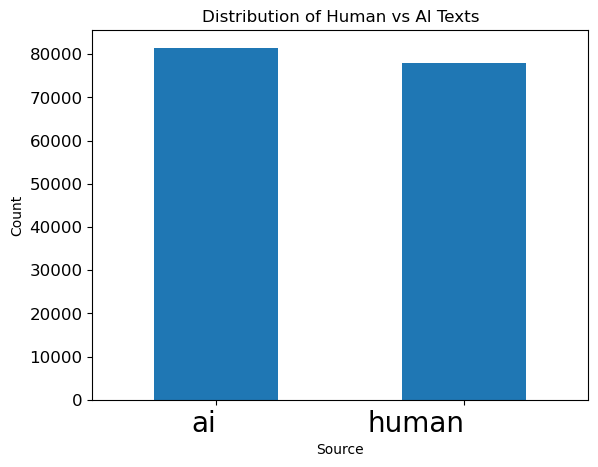

In [ ]:
print(df_small["source"].value_counts())
df_small["source"].value_counts().plot(kind="bar")
plt.title("Distribution of Human vs AI Texts")
plt.xlabel("Source")
plt.ylabel("Count")
plt.xticks(fontsize=20, rotation=0, ha="right")                # Bigger x-ticks, rotated for readability
plt.yticks(fontsize=12)    
plt.show()

In [ ]:
df_small["text_length"] = df_small["text"].str.len()

print("text length by source: ",df_small.groupby("source")["text_length"].mean())

text length by source:  source
ai       378.560318
human    399.418375
Name: text_length, dtype: float64


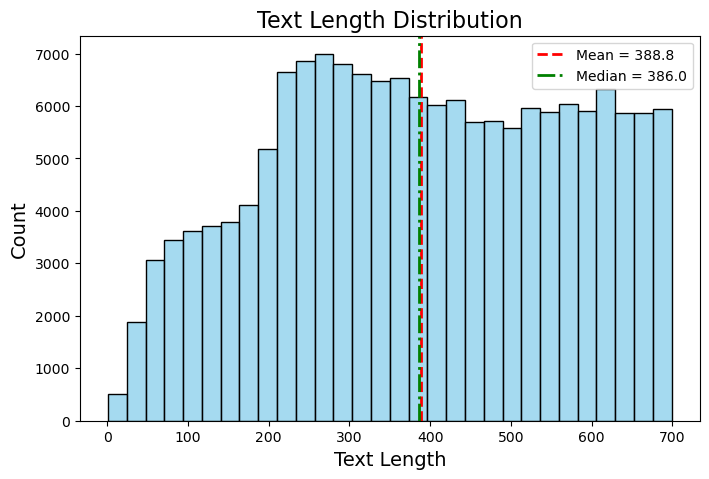

In [ ]:
plt.figure(figsize=(8,5))

# Plot a single histogram (no separation by source)
sns.histplot(df_small["text_length"], bins=30, kde=False, color="skyblue")

# Calculate stats
mean_val = df_small["text_length"].mean()
median_val = df_small["text_length"].median()

# Add lines
plt.axvline(mean_val, color="red", linestyle="--", linewidth=2, label=f"Mean = {mean_val:.1f}")
plt.axvline(median_val, color="green", linestyle="-.", linewidth=2, label=f"Median = {median_val:.1f}")

# Titles & labels
plt.title("Text Length Distribution", fontsize=16)
plt.xlabel("Text Length", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.legend()

plt.show()


In [ ]:
def count_sentences(text):
    if not isinstance(text, str) or not text.strip():
        return 0
    # Split by ., !, ? followed by space or end of string
    sentences = re.split(r'[.!?]+(?:\s|$)', text.strip())
    # Remove empty strings
    sentences = [s for s in sentences if s]
    return len(sentences)

df_small["sentence_count"] = df_small["text"].apply(count_sentences)

print(df_small.groupby("source")["sentence_count"].mean())

source
ai       4.041990
human    4.625415
Name: sentence_count, dtype: float64


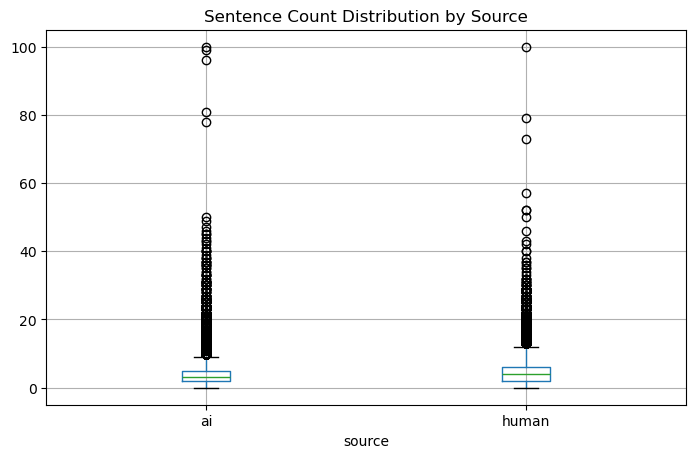

In [ ]:
df_small.boxplot(column="sentence_count", by="source", figsize=(8,5))
plt.title("Sentence Count Distribution by Source")
plt.suptitle("")
plt.show()

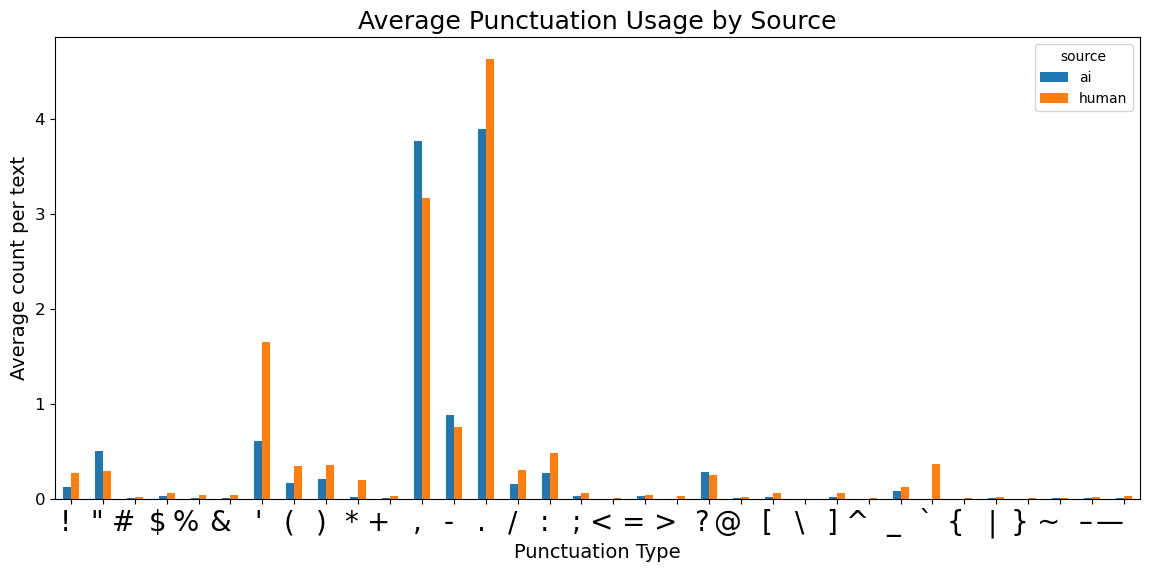

In [ ]:
import string
import re
import matplotlib.pyplot as plt

# Define punctuation characters (add em dash and en dash)
punctuations = string.punctuation + "–—"  # en dash (–) and em dash (—)

# Count occurrences of each punctuation in every text
for p in punctuations:
    # Create safe column names by replacing unusual symbols with readable names
    safe_p = p
    if p == "–":
        safe_p = "endash"
    elif p == "—":
        safe_p = "emdash"
    df_small[f"count_{safe_p}"] = df_small["text"].str.count(re.escape(p))

# Compute averages by source
punct_avg = (
    df_small.groupby("source")[
        [col for col in df_small.columns if col.startswith("count_")]
    ]
    .mean()
    .T
)
punct_avg.index = (
    punct_avg.index.str.replace("count_", "", regex=False)
    .str.replace("endash", "–", regex=False)
    .str.replace("emdash", "—", regex=False)
)

# Plot
punct_avg.plot(kind="bar", figsize=(14, 6))

plt.title("Average Punctuation Usage by Source", fontsize=18)
plt.ylabel("Average count per text", fontsize=14)
plt.xlabel("Punctuation Type", fontsize=14)
plt.xticks(fontsize=20, rotation=0, ha="right")
plt.yticks(fontsize=12)

plt.show()


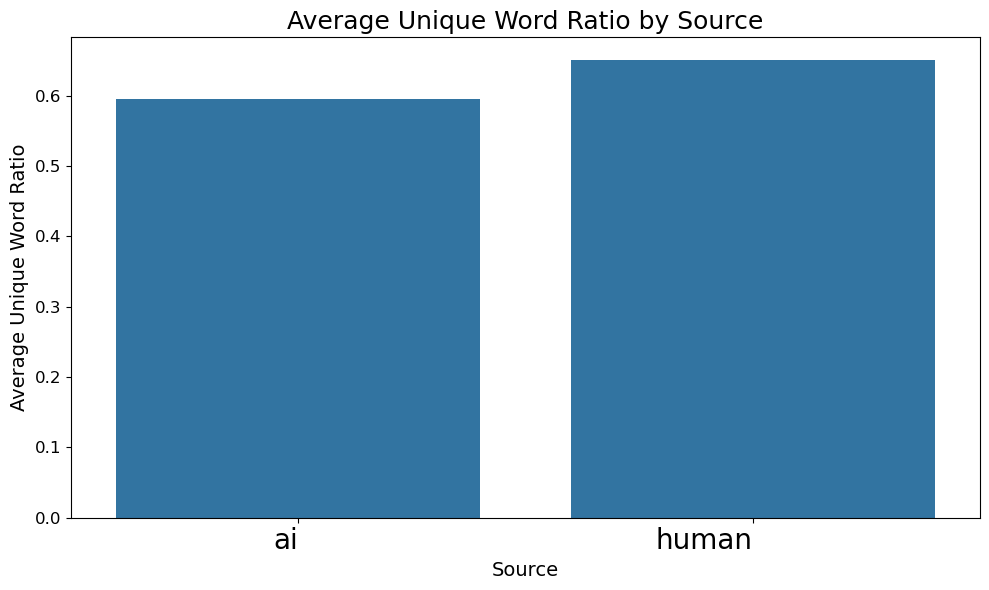

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt

# Convert the Series to a DataFrame and reset the index
avg_unique_ratio = avg_unique_ratio.reset_index()

# Rename columns for clarity
avg_unique_ratio.columns = ["source", "avg_unique_ratio"]

# Plot with seaborn
plt.figure(figsize=(10,6))
sns.barplot(data=avg_unique_ratio, x="source", y="avg_unique_ratio")

plt.title("Average Unique Word Ratio by Source", fontsize=18)
plt.xlabel("Source", fontsize=14)
plt.ylabel("Average Unique Word Ratio", fontsize=14)

plt.xticks(fontsize=20, rotation=0, ha="right")
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Magsihim_AI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Magsihim_AI\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Magsihim_AI\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Magsihim_AI\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger_eng.zip.


True

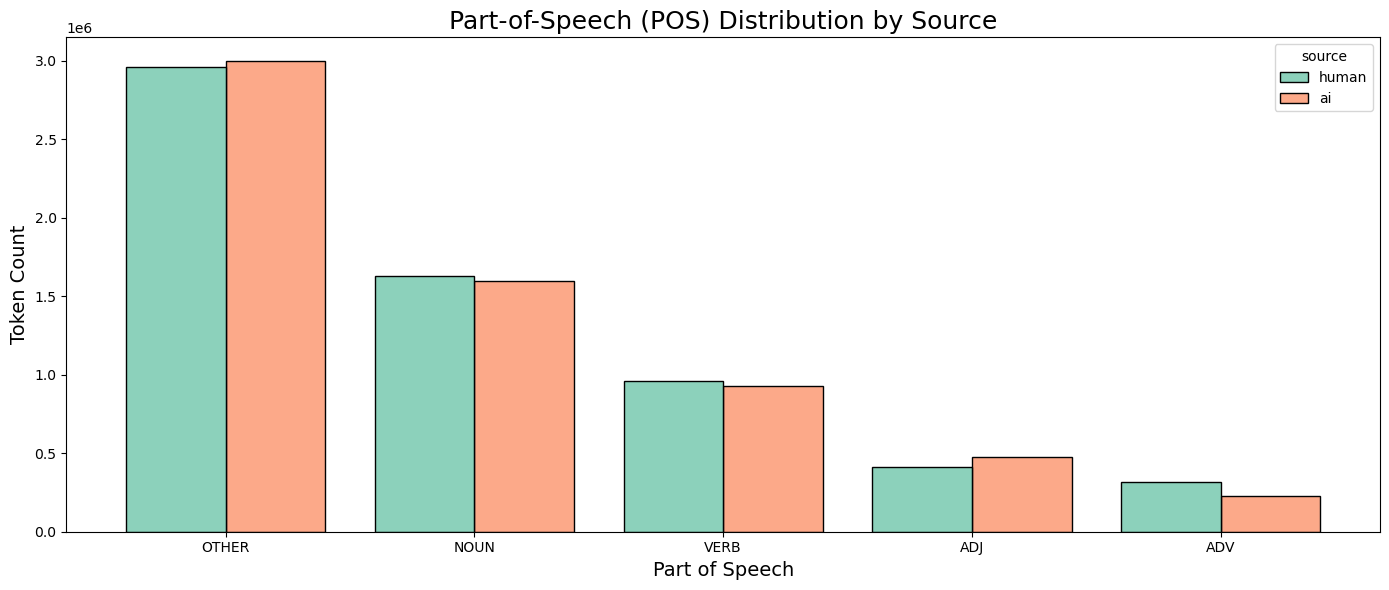

In [ ]:


# --- POS Tagging Function ---
def get_pos_groups(text, source):
    if not isinstance(text, str):  # Skip or handle NaN/non-string
        return []
    tokens = word_tokenize(text)
    tags = pos_tag(tokens)
    pos_data = []
    for _, pos in tags:
        if pos.startswith("N"):
            pos_data.append({"source": source, "pos": "NOUN"})
        elif pos.startswith("V"):
            pos_data.append({"source": source, "pos": "VERB"})
        elif pos.startswith("J"):
            pos_data.append({"source": source, "pos": "ADJ"})
        elif pos.startswith("R"):
            pos_data.append({"source": source, "pos": "ADV"})
        else:
            pos_data.append({"source": source, "pos": "OTHER"})
    return pos_data
# --- Apply to your DataFrame ---
pos_records = []
for _, row in df_small.iterrows():
    pos_records.extend(get_pos_groups(row["text"], row["source"]))

pos_df = pd.DataFrame(pos_records)

plt.figure(figsize=(14, 6))
sns.histplot(data=pos_df, x="pos", hue="source", multiple="dodge", shrink=0.8, palette="Set2")
plt.title("Part-of-Speech (POS) Distribution by Source", fontsize=18)
plt.xlabel("Part of Speech", fontsize=14)
plt.ylabel("Token Count", fontsize=14)
plt.tight_layout()
plt.show()


C:\Users\Magsihim_AI\AppData\Local\Temp\ipykernel_5352\2688842303.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


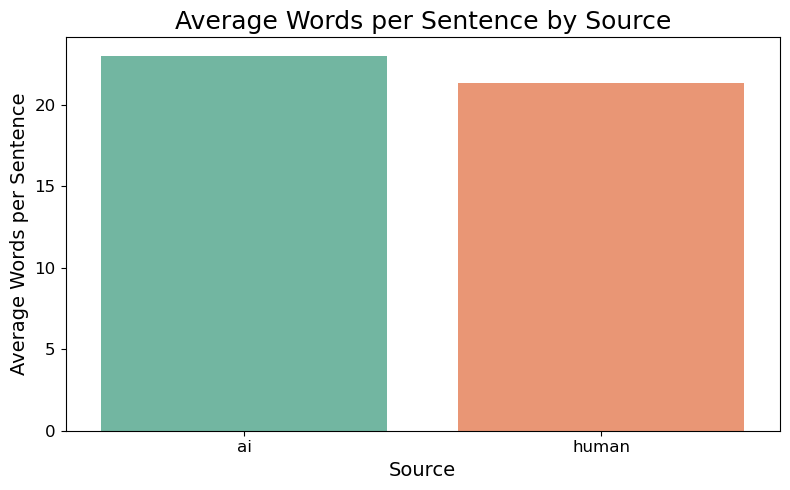

In [ ]:
def avg_words_per_sentence(text):
    if not isinstance(text, str) or not text.strip():
        return 0
    sentences = sent_tokenize(text)
    if not sentences:
        return 0
    word_counts = [len(word_tokenize(s)) for s in sentences]
    return sum(word_counts) / len(sentences)

# --- Compute average words per sentence for each text ---
df_small["avg_words_per_sentence"] = df_small["text"].apply(avg_words_per_sentence)

# --- Aggregate by source (e.g. "human" vs "ai") ---
avg_stats = df_small.groupby("source")["avg_words_per_sentence"].mean().reset_index()

# --- Plot ---
plt.figure(figsize=(8, 5))
sns.barplot(
    data=avg_stats,
    x="source",
    y="avg_words_per_sentence",
    palette="Set2",
    errorbar=None
)

plt.title("Average Words per Sentence by Source", fontsize=18)
plt.xlabel("Source", fontsize=14)
plt.ylabel("Average Words per Sentence", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

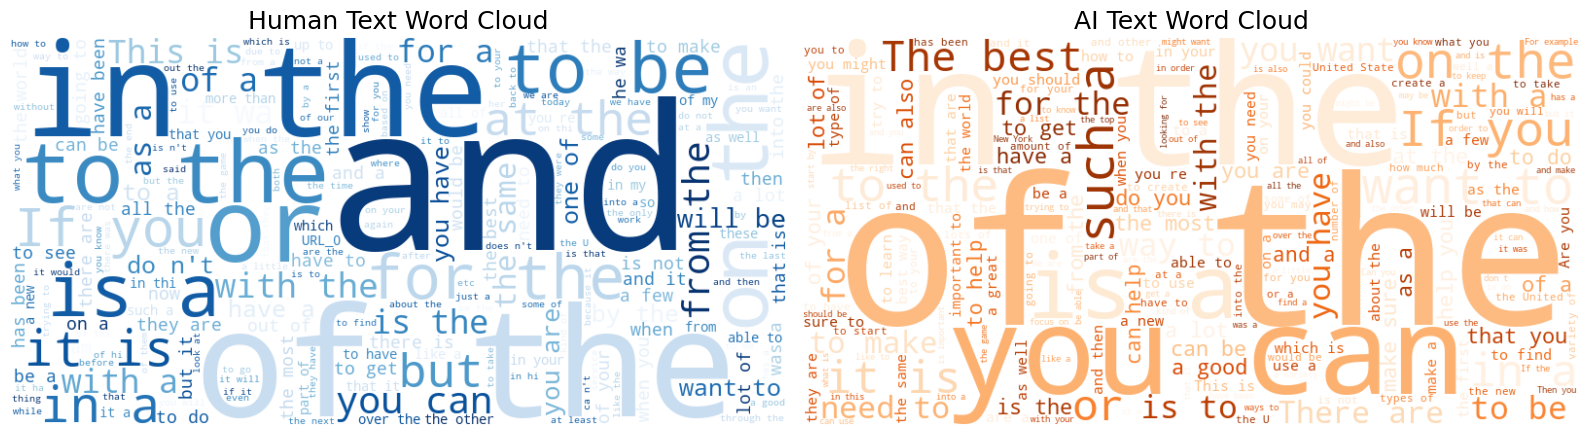

In [ ]:
human_text = " ".join(df_small.loc[df_small["source"].str.lower() == "human", "text"].dropna().astype(str))
ai_text    = " ".join(df_small.loc[df_small["source"].str.lower() == "ai", "text"].dropna().astype(str))

# --- Create word clouds ---
human_wc = WordCloud(width=800, height=400, background_color="white", colormap="Blues", stopwords="english").generate(human_text)
ai_wc    = WordCloud(width=800, height=400, background_color="white", colormap="Oranges", stopwords="english").generate(ai_text)

# --- Plot side by side ---
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].imshow(human_wc, interpolation="bilinear")
axes[0].set_title("Human Text Word Cloud", fontsize=18)
axes[0].axis("off")

axes[1].imshow(ai_wc, interpolation="bilinear")
axes[1].set_title("AI Text Word Cloud", fontsize=18)
axes[1].axis("off")

plt.tight_layout()
plt.show()

# embeddings

In [3]:
def preprocess_text(s):
    s = str(s).lower()
    s = re.sub(r'\s+', ' ', s)                 # collapse whitespace
    s = re.sub(r'http\S+|www\.\S+', '', s)     # remove URLs
    s = re.sub(r'@\w+', '', s)                 # remove mentions
    s = re.sub(r'[^a-z0-9\s]', ' ', s)         # keep alphanum only
    s = re.sub(r'\s+', ' ', s).strip()
    return s

df_small['text_clean'] = df_small['text'].apply(preprocess_text)
# tokenize to lists of words
df_small['tokens'] = df_small['text_clean'].apply(word_tokenize)

In [ ]:
#tf idf

# Copy the data
df_small_copy = df_small.copy()
df_small_copy = df_small_copy.dropna(subset=['text']).reset_index(drop=True)
df_small_copy['text'] = df_small_copy['text'].astype(str)

# Initialize TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=5000, token_pattern=r'\b[a-zA-Z]{2,}\b')

# Fit + transform (returns sparse matrix)
tfidf_matrix = vectorizer.fit_transform(df_small_copy['text'])

tfidf_sample = pd.DataFrame(
    tfidf_matrix[:5].toarray(),
    columns=vectorizer.get_feature_names_out()
)

# Show the first 5 rows
tfidf_sample.head()

In [ ]:
#bag of words


# Initialize CountVectorizer (BoW)
vectorizer = CountVectorizer(max_features=5000, token_pattern=r'\b[a-zA-Z]{2,}\b')


# Fit + transform the text data
bow_matrix = vectorizer.fit_transform(df_small_copy['text'])

# inspect a small sample
sample_bow = pd.DataFrame(
    bow_matrix[:5].toarray(),
    columns=vectorizer.get_feature_names_out()
)
sample_bow.head()

In [6]:
#word2vec

# sentences = list of token lists
sentences = df_small['tokens'].tolist()

w2v_params = {
    'sentences': sentences,
    'vector_size': 100,   # embedding dimension (try 100 or 300)
    'window': 5,
    'min_count': 2,       # words with freq <2 ignored; lower if small dataset
    'workers': 4,
    'sg': 1,              # 1 = skip-gram, 0 = CBOW
    'epochs': 10
}

w2v_model = Word2Vec(**w2v_params)

# Save model for later
w2v_model.save("word2vec_small_df.model")
# Save keyed vectors (smaller)
w2v_model.wv.save_word2vec_format("word2vec_small_df.bin", binary=True)


In [7]:
#word2vec

dim = w2v_model.vector_size

def doc_vector_avg(tokens):
    vecs = []
    for t in tokens:
        if t in w2v_model.wv:
            vecs.append(w2v_model.wv[t])
    if len(vecs) == 0:
        return np.zeros(dim)
    return np.mean(vecs, axis=0)

df_small['w2v_doc_embed'] = df_small['tokens'].apply(doc_vector_avg).tolist()


In [8]:
df_small.head()

,source,id,text,text_length,text_clean,tokens,w2v_doc_embed
0,human,307353,Our founders are experienced tech industry pro...,333,our founders are experienced tech industry pro...,"[our, founders, are, experienced, tech, indust...","[-0.25081867, -0.005118007, 0.019288272, 0.143..."
1,human,281747,William W. Campbell Lippincott Williams & Wilk...,678,william w campbell lippincott williams wilkins...,"[william, w, campbell, lippincott, williams, w...","[-0.103021584, 0.121238895, -0.030258246, 0.23..."
2,human,418560,"Bagpipes ( and bugles , also used in such fune...",643,bagpipes and bugles also used in such funerals...,"[bagpipes, and, bugles, also, used, in, such, ...","[-0.115199275, 0.05293104, -0.25833294, 0.1851..."
3,human,727582,"I finished it in one binge read, and I think i...",549,i finished it in one binge read and i think it...,"[i, finished, it, in, one, binge, read, and, i...","[-0.16111967, 0.086835325, -0.14055875, 0.2589..."
4,human,427526,The longer the blonder the hair the more press .,48,the longer the blonder the hair the more press,"[the, longer, the, blonder, the, hair, the, mo...","[-0.099905014, 0.14980024, 0.042916134, 0.2887..."


In [ ]:

# Path to your GloVe file
glove_path = r"C:\Users\Magsihim_AI\Downloads\glove.6B\glove.6B.100d.txt"

# Function to load GloVe embeddings
def load_glove(glove_path):
    embeddings = {}
    with open(glove_path, 'r', encoding='utf8') as f:
        for line in f:
            parts = line.strip().split()
            word = parts[0]
            vec = np.asarray(parts[1:], dtype='float32')
            embeddings[word] = vec
    return embeddings

# Load GloVe
glove_emb = load_glove(glove_path)

# Get dimension of embeddings
glove_dim = len(next(iter(glove_emb.values())))
print("GloVe dimension:", glove_dim)


GloVe dimension: 100


In [11]:
#glove

def load_glove(glove_path):
    embeddings = {}
    with open(glove_path, 'r', encoding='utf8') as f:
        for line in f:
            parts = line.strip().split()
            word = parts[0]
            vec = np.asarray(parts[1:], dtype='float32')
            embeddings[word] = vec
    return embeddings

glove_emb = load_glove(glove_path)
print("Words loaded:", len(glove_emb))
print("Vector size:", len(next(iter(glove_emb.values()))))


Words loaded: 400000
Vector size: 100


In [12]:
#glove

def glove_doc_avg(tokens):
    vecs = [glove_emb[t] for t in tokens if t in glove_emb]
    if not vecs: return np.zeros(glove_dim)
    return np.mean(vecs, axis=0)

df_small['glove_doc_embed'] = df_small['tokens'].apply(glove_doc_avg).tolist()

In [13]:
df_small.head()

,source,id,text,text_length,text_clean,tokens,w2v_doc_embed,glove_doc_embed
0,human,307353,Our founders are experienced tech industry pro...,333,our founders are experienced tech industry pro...,"[our, founders, are, experienced, tech, indust...","[-0.25081867, -0.005118007, 0.019288272, 0.143...","[-0.0332538, 0.21016517, 0.08414716, -0.179783..."
1,human,281747,William W. Campbell Lippincott Williams & Wilk...,678,william w campbell lippincott williams wilkins...,"[william, w, campbell, lippincott, williams, w...","[-0.103021584, 0.121238895, -0.030258246, 0.23...","[-0.2239646, 0.12922347, 0.16484891, -0.039816..."
2,human,418560,"Bagpipes ( and bugles , also used in such fune...",643,bagpipes and bugles also used in such funerals...,"[bagpipes, and, bugles, also, used, in, such, ...","[-0.115199275, 0.05293104, -0.25833294, 0.1851...","[-0.13754454, 0.27030092, 0.21096799, -0.24696..."
3,human,727582,"I finished it in one binge read, and I think i...",549,i finished it in one binge read and i think it...,"[i, finished, it, in, one, binge, read, and, i...","[-0.16111967, 0.086835325, -0.14055875, 0.2589...","[-0.08726987, 0.2157174, 0.4101732, -0.2712018..."
4,human,427526,The longer the blonder the hair the more press .,48,the longer the blonder the hair the more press,"[the, longer, the, blonder, the, hair, the, mo...","[-0.099905014, 0.14980024, 0.042916134, 0.2887...","[-0.06518066, -0.017382225, 0.34586608, -0.382..."
